In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../") # Add parent directory to path
from mfbox import gokunet_alpha 


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# load input data
x_test = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/test_input.txt")
# normalize input data
# bounds = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/input_limits.txt")
bounds_path = "../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/input_limits.txt"
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/test_output.txt")
y_test = 10**y_test


In [4]:
# load model
fold=11
emu = gokunet_alpha(path_LA=f"../models/N_L1A_z0_0c/model_fold{fold}.pth",path_HA=f"../models/N_LHA_z0_0c/model_fold{fold}.pth", path_L2=f"../models/N_L2_z0_0c/model_fold{fold}.pth", path_LH=f"../models/N_xLH_stitch_z0_0c/model_fold{fold}.pth", bounds_path=bounds_path)

/home/yang/Desktop/GitReps/GokuNet/loocv/../mfbox.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [5]:
k, y_h_pred = emu.predict(x_test)
k_1, y_l1_pred = emu.predict_LA(x_test)
k_2, y_l2_pred = emu.predict_L2(x_test)

In [6]:
k_1.shape

(32,)

In [7]:
k.shape

(64,)

In [8]:
y_l1_pred.shape

(15, 32)

In [9]:
k.max()

np.float64(8.009795385841095)

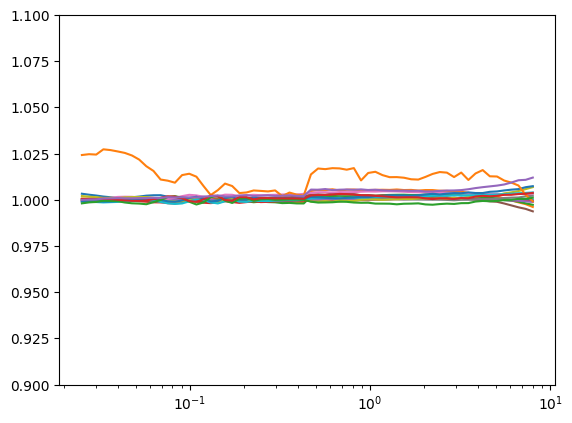

In [10]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    plt.semilogx(k, y_h_pred[i] / y_test[i])
# limit the y-axis 
plt.ylim(0.9, 1.1)
plt.show()

In [11]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred - y_test) / y_test)
print("Relative Mean Absolute Error:", rel_err) 

Relative Mean Absolute Error: 0.0023040075683112824


In [12]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred[:,:32] - y_test[:,:32]) / y_test[:,:32])
print("Relative Mean Absolute Error:", rel_err)

Relative Mean Absolute Error: 0.0016688439242699595


In [13]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred[:,32:] - y_test[:,32:]) / y_test[:,32:])
print("Relative Mean Absolute Error:", rel_err)

Relative Mean Absolute Error: 0.0029391712123526055


In [14]:
(0.012757600941699561+0.028226519241934728)/2

0.020492060091817144

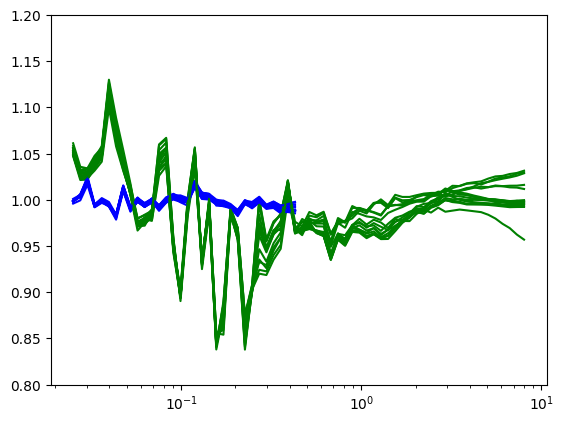

In [15]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    # plt.semilogx(k, y_h_pred[i] / y_test[i])
    plt.semilogx(k_1, y_l1_pred[i] / y_test[i][:32], color="blue")
    plt.semilogx(k_2, y_l2_pred[i] / y_test[i], color="green")
# limit the y-axis
plt.ylim(0.8, 1.2)
plt.show()

In [16]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_h_pred) - np.log10(y_test))**2)
print("Mean Square Error:", mse)

Mean Square Error: 3.4160835222140414e-06


In [17]:
# load HF training data
x_th = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/train_input_fidelity_1.txt")
y_th = np.loadtxt("../data/narrow/matter_power_564_Box250_Part750_15_Box1000_Part3000_z0/train_output_fidelity_1.txt")
y_th = 10**y_th

In [18]:
# compare the prediction with the training data
_, y_th_pred = emu.predict(x_th)

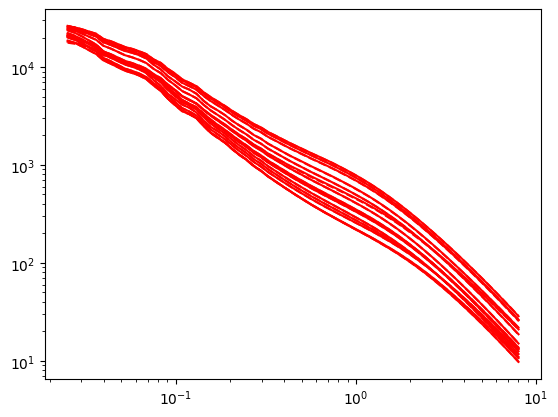

In [19]:


# plot in log-log scale
plt.figure()

# loop over all the test data 
for i in range(y_h_pred.shape[0]):
    plt.loglog(k, y_th[i], color="red", linestyle="--", label="True Data") 
    plt.loglog(k, y_th_pred[i], color="red", label="NN Prediction")
# plt.legend()
plt.show()


In [20]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_th_pred) - np.log10(y_th))**2)
print("Mean Square Error:", mse)

Mean Square Error: 3.4160835222140414e-06


In [21]:
# loop over all k-folds to get the prediction
y_h_pred = []
kfolds = 15

for i in range(kfolds):
    emu = gokunet_alpha(path_LA="../models/N_L1A_z0_0c/model_fold{}.pth".format(i),path_HA="../models/N_LHA_z0_0c/model_fold{}.pth".format(i), path_L2="../models/N_L2_z0_0c/model_fold{}.pth".format(i), path_LH="../models/N_xLH_stitch_z0_0c/model_fold{}.pth".format(i), bounds_path=bounds_path)
    _, y_h_pred_temp = emu.predict(x_test)
    y_h_pred.append(y_h_pred_temp[i])

y_h_pred = np.array(y_h_pred)


In [22]:
y_h_pred


array([[2.02366445e+04, 1.90704609e+04, 1.75128262e+04, 1.58940938e+04,
        1.44580273e+04, 1.23908750e+04, 1.14579854e+04, 1.05206777e+04,
        9.66244238e+03, 9.17606543e+03, 8.63821973e+03, 7.95157373e+03,
        6.87122949e+03, 6.06153711e+03, 5.04513184e+03, 4.37966016e+03,
        3.80498975e+03, 3.52604761e+03, 3.20133789e+03, 2.68458618e+03,
        2.29356006e+03, 2.04500879e+03, 1.82222095e+03, 1.57268738e+03,
        1.38072339e+03, 1.23039819e+03, 1.06861841e+03, 9.59228149e+02,
        8.41656555e+02, 7.53638245e+02, 6.75180054e+02, 6.05937134e+02,
        5.46645996e+02, 4.94927887e+02, 4.47186432e+02, 4.07090454e+02,
        3.71201019e+02, 3.39578217e+02, 3.10587280e+02, 2.85009460e+02,
        2.60259277e+02, 2.38869507e+02, 2.18412628e+02, 1.99426224e+02,
        1.81042313e+02, 1.64005997e+02, 1.47951233e+02, 1.32680557e+02,
        1.18396210e+02, 1.05005798e+02, 9.25677338e+01, 8.10967178e+01,
        7.07018509e+01, 6.13404274e+01, 5.30219231e+01, 4.560170

In [23]:
from scipy.interpolate import interp1d

def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

def rMAE_av_cosmo(k_test, y_test, k_pred, y_pred, exclude=None):
    Ps_pred = y_pred
    Ps_sim = y_test
    k_sim = k_test
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_pred, Ps_pred)
    if exclude is not None:  # exclude some cosmologies
        rAEs = np.delete(rAEs, exclude, axis=0)
    rMAE_av = np.mean(rAEs, axis=0)

    # rAE_av_k = np.mean(rAEs, axis=1)

    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

In [24]:
from matplotlib import patches


average over k: 0.00944392152944213


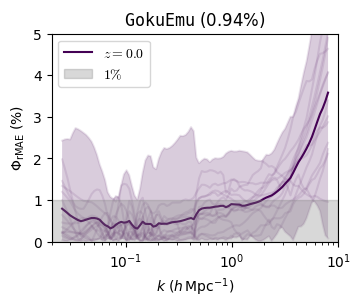

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3.7, 2.7))

# plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

cmap = "viridis"
cmap = plt.get_cmap(cmap)
color_list = [x for x in cmap(np.arange(len(zs[:6]))/(len(zs[:6])-1))]

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')

i = 0
c = color_list[i]
# k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
# k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))


k_com, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(k, y_test, k, y_h_pred, exclude=None)
# rMAE_zs.append(rMAE.mean())
# plot all cosmologies
for j in range(rAEs.shape[0]):
    ax.plot(k_com, rAEs[j]/1e-2, color=c, alpha=0.1)

ax.plot(k_com, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
ax.fill_between(k_com, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
print('average over k:', rMAE.mean())
    

# title
ax.set_title(r'$\tt{GokuEmu}$' + f' ({100*rMAE.mean():.2f}%)')


ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 5)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square1 = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='gray', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
ax.add_patch(square1)
# ax.add_patch(square1)
ax.legend(loc='upper left')


# plt.show()
# plt.savefig('loo_against_W.pdf', bbox_inches='tight')